
# The 2nd place solution of the [RetailHero Uplift Modelling contest ](https://retailhero.ai/c/uplift_modeling/overview)  

### To open Notebook for read, use [nbviewer](!add)

![Contest image](https://retailhero.ai/static/img/%D0%A55_res/uplift_modeling_banner.png)

## Summary of the solution:
###### Main points to get good results in this competition:
-	Use few features, pre-select features. My best submission used only 6 ones!


-	Make NOT very complex estimators for fitting. I used mainly different gradient boosting realizations (Catboost / Xgboost / Lightgbm), best results gave models with trees of death 1-2.


-	Use Class transformation approach for uplift modelling.


- Try to make more accurate local validation and do not rely only on public validation score. For testing hypotheses I used to make N (N = 30, 50) train - test splits and calculate test scores mean and standard deviation for making decisions.

### Additional info:
  
  Package with different uplift model realizations:  
 [uplift modelling package](https://github.com/maks-sh/scikit-uplift/)

  Tutorial about uplift and approaches (in Russian):  
 [uplift modeling approaches article](https://habr.com/ru/company/ru_mts/blog/485980/)
    
  Additional code with my feature engenearing, experimemts and validation:  
 [retail hero research](!INSER LINK)

##### code is on py37, requirements:
- numpy==1.16.1
- pandas==0.24.1
- scikit-learn==0.21.3
- scikit-uplift==0.0.3
- xgboost==0.90
- matplotlib==3.1.1

In [1]:
import gc
import pandas as pd
import numpy as np
from datetime import datetime

from xgboost import XGBClassifier
from sklift.models import ClassTransformation

from sklift.metrics import uplift_at_k
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from dstools.spark import init_spark2

spark = init_spark2({
    "appName": "2nd_place_solution",
    "spark.yarn.queue": "default",
    "spark.driver.memory": "32g",
    "spark.executor.memoryOverhead": "2048",
    "spark.driver.extraJavaOptions": "-XX:ThreadStackSize=81920",
    "spark.executor.extraJavaOptions": "-XX:ThreadStackSize=81920",
    "spark.driver.maxResultSize": "45g",
    "spark.driver.memory": "45g"
})

#### LOAD INITIAL DATA

In [3]:
# read all data
sdf_cliens = spark.read.csv('/user/mvshevc5/retailhero/clients.csv', inferSchema=True, header=True)
sdf_purchase = spark.read.csv('/user/mvshevc5/retailhero/purchases.csv', inferSchema=True, header=True)
sdf_products = spark.read.csv('/user/mvshevc5/retailhero/products.csv', inferSchema=True, header=True)
sdf_train = spark.read.csv('/user/mvshevc5/retailhero/uplift_train.csv', inferSchema=True, header=True)
sdf_test = spark.read.csv('/user/mvshevc5/retailhero/uplift_test.csv', inferSchema=True, header=True)

In [ ]:
df_clients = sdf_cliens.toPandas()
df_train = sdf_train.toPandas()
df_test = sdf_test.toPandas()
df_products = sdf_products.toPandas()
df_purchases = sdf_purchase.toPandas()

In [6]:
df_clients = df_clients.set_index('client_id')
df_train = df_train.set_index('client_id')
df_test = df_test.set_index('client_id')

df_purchases.loc[:,'transaction_datetime'] =  pd.to_datetime(df_purchases['transaction_datetime'])
df_clients.loc[:,'first_issue_date'] = pd.to_datetime(df_clients['first_issue_date'])
df_clients.loc[:,'first_redeem_date'] = pd.to_datetime(df_clients['first_redeem_date'])

In [7]:
# df_clients = pd.read_csv(
#     'data/clients.csv', 
#     index_col='client_id', 
#     parse_dates=['first_issue_date', 'first_redeem_date']
# )
# df_purchases = pd.read_csv(
#     'data/purchases.csv'
#     index_col='client_id', 
#     parse_dates=['transaction_datetime']
# )
# df_dtrain = pd.read_csv('data/uplift_train.csv', index_col='client_id')
# df_test = pd.read_csv('data/uplift_test.csv', index_col='client_id')

#### MAKE FEATURES FOR TRAIN AND TEST

###### Final second place submission used only 6 features: 

'first_redeem_date' - make date as an integer feature

In [8]:
df_clients['first_redeem_date'] =\
    df_clients['first_redeem_date']\
        .fillna(datetime(2019, 3, 19, 0, 0))

df_clients.loc[:, 'first_redeem_date'] =\
    ((df_clients['first_redeem_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1d'))

Aggregate df_purchases data

In [9]:
# two -level aggregation: 

# 1. aggregate to (client, transaction) take one row only 
#  ('express_points_spent', 'purchase_sum' - same for one transaction)

# 2. aggregate all transactions to client.


df_purch = df_purchases\
    .groupby(['client_id','transaction_id'])[['express_points_spent', 'purchase_sum']]\
    .last()\
    .groupby('client_id')\
    .agg({
        'express_points_spent': ['mean', 'sum'], 
        'purchase_sum': ['sum']
    })
    
# set readable column names:
df_purch.columns =\
    ['express_spent_mean', 'express_points_spent_sum', 'purchase_sum__sum']

In [10]:
#'regular_points_received_sum_last_m'

reg_points_last_m = df_purchases[
        df_purchases['transaction_datetime'] > '2019-02-18'
    ]\
    .groupby(['client_id', 'transaction_id'])['regular_points_received']\
    .last()\
    .groupby('client_id')\
    .sum()
    
reg_points_last_m = pd.DataFrame({
    'regular_points_received_sum_last_m': reg_points_last_m  
})

Make 'transaction_datetime' from purchases data frame as integer. 

Join clients df and purchases df and calculate difference between 'transaction_datetime' and ''first_redeem_date' (date_diff).

In [11]:
df_purchases.loc[:,'purch_day'] =\
     ((df_purchases['transaction_datetime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1d'))

Calculate features from purchases data for all transactions after redeem date:

In [12]:
# 'after_redeem_sum'

df_purch_joined = pd.merge(
    df_purchases[
        ['client_id', 'purch_day', 'transaction_id', 'purchase_sum']
    ],
    df_clients\
    .reset_index()[
        ['client_id', 'first_redeem_date']
    ], on='client_id', how='left')

df_purch_joined = df_purch_joined\
    .assign(date_diff=\
        df_purch_joined['first_redeem_date'] - df_purch_joined['purch_day']
    )

df_purch_agg = df_purch_joined[
        df_purch_joined['date_diff'] <= 0
    ]\
    .groupby(
        ['client_id', 'transaction_id']
    )\
    .last()\
    .groupby('client_id')['purchase_sum']\
    .sum()
    
after_redeem_sum = pd.DataFrame(data={
    'after_redeem_sum': df_purch_agg
})

del df_purch_joined, df_purch_agg
gc.collect();

'purch_delta' -  difference in days between last and first transaction  

In [13]:
df_purch_delta_agg = df_purchases\
    .groupby('client_id')\
      .agg({
          'purch_day': ['max', 'min']
      })

df_purch_delta = pd.DataFrame(
    data=df_purch_delta_agg['purch_day']['max'] -\
        df_purch_delta_agg['purch_day']['min'] + 1,
    columns=['purch_delta']
)

del df_purch_delta_agg
gc.collect();

------

Concat all data together:

In [14]:
df_feats = pd.concat([
    df_clients[['first_redeem_date']], 
    df_purch, 
    df_purch_delta, 
    reg_points_last_m, 
    after_redeem_sum
], axis=1, sort=False)

df_feats = df_feats\
    .assign(
        avg_spent_perday=\
            df_feats['purchase_sum__sum'] / df_feats['purch_delta'],
        after_redeem_sum_perday =\
            df_feats['after_redeem_sum'] / df_feats['purch_delta']
    )\
    .drop([
        'purch_delta', 'purchase_sum__sum', 'after_redeem_sum'
    ], axis=1
    )

In [15]:
# train and test features
print(df_feats.shape)
df_feats.head(2)

(400162, 6)


,first_redeem_date,express_spent_mean,express_points_spent_sum,regular_points_received_sum_last_m,avg_spent_perday,after_redeem_sum_perday
000012768d,17535,0.0,0.0,10.0,26.951923,26.951923
000036f903,17279,0.0,0.0,13.7,89.136364,89.136364


Make train and test data: join clints ids and treatment and target for train.

In [16]:
# train data:
df_train_feats = df_train\
    .join(
        df_feats, 
        how='left'
    )
    
df_test_feats = df_test\
    .join(
        df_feats, 
        how='left'
    )
    
print(f'Train df shape: {df_train_feats.shape}')
print(f'Test df shape: {df_test_feats.shape}')

Train df shape: (200039, 8)
Test df shape: (200123, 6)


In [17]:
# save final train / test data 
df_train_feats.to_csv('data/retail_hero_final_model_train_data.csv')
df_test_feats.to_csv('data/retail_hero_final_model_test_data.csv')

-----

#### SET  MODEL
Use uplift class tranformation approach for uplift prediction with XGBoost as an estimator.

In [18]:
xgb_est_params = {
    'max_depth':2,
    'learning_rate': 0.2, 
    'n_estimators': 100,
    'nthread':40,
    'n_gpus':0,
    'seed':42
}

estimator = XGBClassifier(
    **xgb_est_params
)

uplift_model_cl_tr = ClassTransformation(
    estimator=estimator
)

-----

#### FIT MODEL ON ALL TRAIN DATA

In [ ]:
uplift_model_cl_tr.fit(
    X=df_train_feats\
        .drop(
            ['treatment_flg', 'target'], 
            axis=1
        ),
    y=df_train_feats['target'],
    treatment=df_train_feats['treatment_flg']
)

--------

#### Make predictions on whole train and test sets.

#### Calculate uplift@30% metric on train data.

###### **NOTE: In this contest uplift@30% metric calculates as follows: 
All test data are sorted in descending order by 'predicted uplift'. Then calculates target share / conversion in top 30% of treatment group and conversion in top 30% of control group SEPARATELY. Metric is then the difference between two conversions.
<br>

 Usually uplift@30% metric calculates differently. Firstly selects top 30% of ALL test data and only then calculates conversion  in treatment and control group and they are subtracted.

In [20]:
# predicts
uplift_tr = uplift_model_cl_tr.predict(
    df_train_feats\
        .drop(['treatment_flg', 'target'], axis=1),
)

uplift_ts = uplift_model_cl_tr.predict(
    df_test_feats
)

In [21]:
# score on train:
df_train_scores = df_train_feats[['treatment_flg', 'target']]\
    .assign(uplift_score=uplift_tr)
    
train_score = uplift_at_k(
    y_true=df_train_scores['target'],
    uplift=df_train_scores['uplift_score'],
    treatment=df_train_scores['treatment_flg']
)

print(f'Uplift@30% on train data: {train_score:.3f}')

Uplift@30% on train data: 0.105


#### Make submit:

In [22]:
df_submit = df_test_feats\
    .assign(uplift=uplift_ts)[['uplift']]

print(f'Submit data shape: {df_submit.shape}\n')
df_submit.head(2)

df_submit.to_csv('submissions/retail_hero_2nd_place_submit.csv')

!head -5 submissions/retail_hero_2nd_place_submit.csv

Submit data shape: (200123, 1)

client_id,uplift
000048b7a6,0.03721845
000073194a,0.019023776
00007c7133,0.032182574
00007f9014,0.016914487


-----

------

##### FEATURE IMPORTANCE

There is the area of research, how to calculate feature importance in uplift models.  

Here feature importance is just vanilla information gain in XGBoost estimator, used in Class transformation approach.


In [23]:
df_feat_imp = pd.DataFrame([
    uplift_model_cl_tr\
        .estimator\
        .get_booster()\
        .get_score(importance_type='gain')
        ]
).T.reset_index()

df_feat_imp.columns =\
    ["feature", "value"]
    
df_feat_imp\
    .sort_values('value', ascending=False)

,feature,value
4,first_redeem_date,64.531791
2,express_points_spent_sum,14.171003
3,express_spent_mean,14.151961
5,regular_points_received_sum_last_m,7.514503
1,avg_spent_perday,5.645311
0,after_redeem_sum_perday,4.776374


------

##### PLOT ULIFT PREDICTIONS FOR TRAIN / TEST DATA

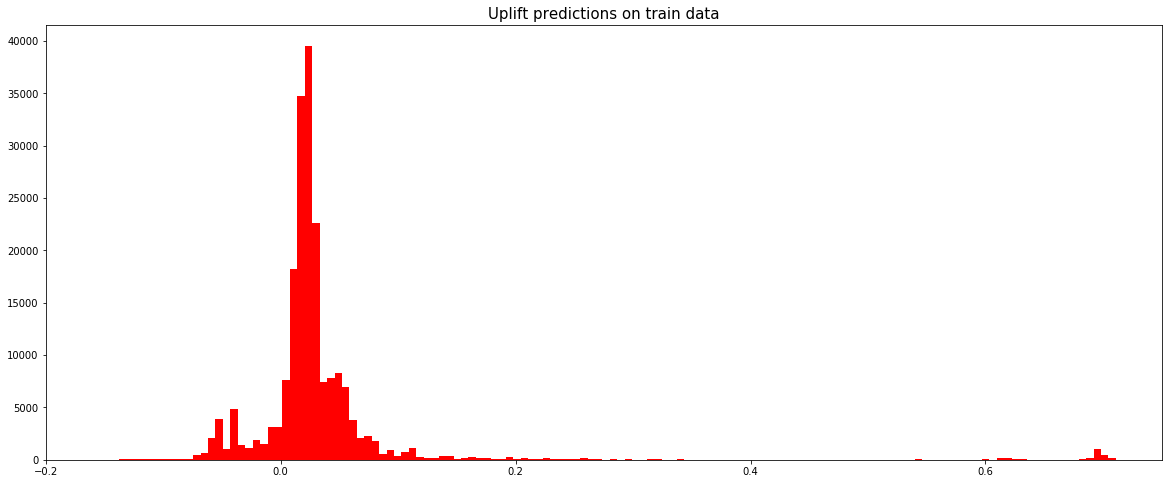

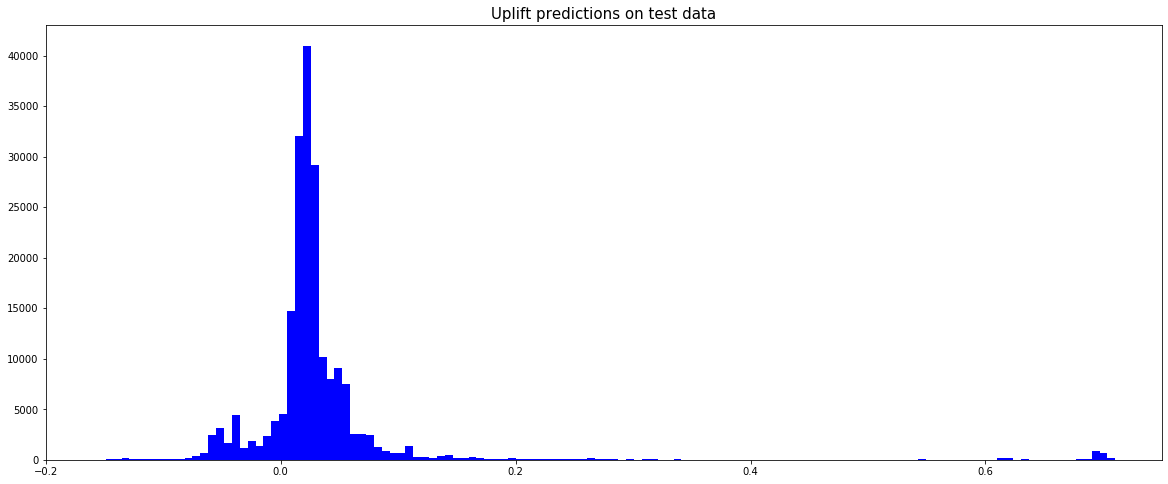

In [24]:
plt.figure(figsize=(20, 8));

plt.hist(
    df_train_scores['uplift_score'],
    bins=200, 
    color='red', 
);

plt.xlim(-0.2, 0.75);
plt.title('Uplift predictions on train data', size=15);


plt.figure(figsize=(20, 8));

plt.hist(
    df_submit['uplift'],
    bins=200, 
    color='blue', 
);

plt.xlim(-0.2, 0.75);
plt.title('Uplift predictions on test data', size=15);

Looks quite simmilar.

----